Aquest codi llegeix els fitxers amb les dades de les estadístiques dels jugadors i en treu les classificacions.

In [1]:
#!pip install numpy==1.25.2
#!pip uninstall xarray scipy netCDF4
#!pip install xarray scipy netCDF4
#!pip install pybin11 --upgrade

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

In [3]:
# Definim tab20 com la paleta per defecte dels plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab20.colors)

In [4]:
# Llegim les dades
dataarray = xr.open_dataset('stats.nc', engine='scipy')
dataarray

<xarray.Dataset> Size: 2kB
Dimensions:    (player: 15, matchday: 13)
Coordinates:
  * player     (player) object 120B 'Alejandro' 'Antía' ... 'Tiziano' 'Víctor'
  * matchday   (matchday) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    WinPlayed  (matchday, player) float64 2kB ...

In [5]:
# Extreiem els noms dels jugadors i les jornades
players_names = dataarray['player'].astype(str).values # noms dels jugadors
matchdays = dataarray['matchday'] # array de números de jornades

In [7]:
# Extreiem els valors de victòries / jugats de l'última jornada
winplayed_values = dataarray['WinPlayed'].isel(matchday = -1).values

# Ordenem de major a menor
winplayed_sorted_idx = np.argsort(winplayed_values)[::-1] # índexs d'ordre (revertim per fer de major a menor)
winplayed_sorted = winplayed_values[winplayed_sorted_idx] # ordenem
winplayed_sorted = np.round(winplayed_sorted, 2) # arrondonim els valors a 2 xifres decimals

players_names_sorted = players_names[winplayed_sorted_idx] # ordenem els noms dels jugadors

#Posem els resultats a una taula (DataFrame)
winplayed_stats = pd.DataFrame(np.array([players_names_sorted, winplayed_sorted]).T, index = np.arange(1, players_names_sorted.shape[0]+1))
caption = "Games won / Games played (Matchday %.1d)" % (matchdays[-1])
winplayed_stats = winplayed_stats.style.set_caption(caption) # afegim títol al dataframe

# Guardem la taula en HTML per mostrar-la al README
winplayed_stats.to_html('results/winplayed_stats.html')

winplayed_stats

,0,1
1,Tiziano,1.0
2,Simone,1.0
3,Dani,0.65
4,Antía,0.6
5,Luis,0.51
6,Víctor,0.5
7,Pablo,0.5
8,Pau,0.49
9,Guille,0.46
10,Pedro,0.41


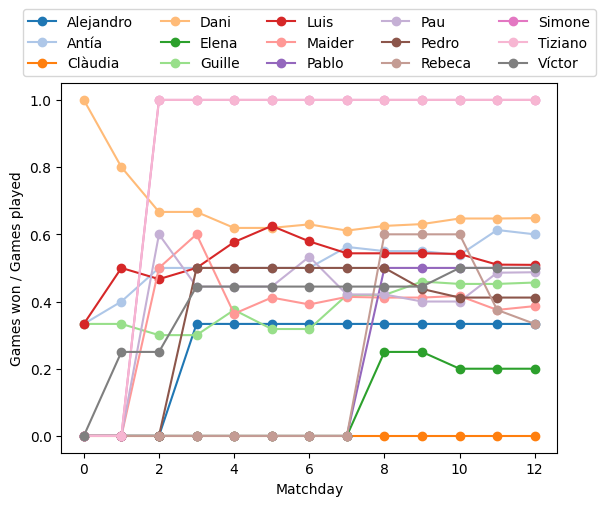

In [9]:
# Fem un gràfic de l'evolució del paràmetre a cada jornada
winplayed_values = dataarray['WinPlayed']

for player in players_names:
    winplayed_evolution = winplayed_values.sel(player = player)
    winplayed_evolution_values = winplayed_evolution.values

    plt.plot(matchdays, winplayed_evolution_values, marker='o', label=player)
    
plt.legend(bbox_to_anchor = ( 0.5, 1.), ncol = 5, loc = 'lower center')
plt.xlabel("Matchday")
plt.ylabel("Games won / Games played")

# Guardem la figura per poderla posar al README
plt.savefig('results/winplayed_stats.png', dpi=300, bbox_inches='tight')